In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import analysis
from xgboost import XGBRegressor

In [60]:
df = pd.read_csv("Files/data.csv")
df.head(5)

,Titles,Price,Location,Rooms,Areas,Bathrooms,Listing Type,Useful area,Gross area,Construction year,Energetic certificate,Enterprise,Neighborhood,City,State
0,Apartamento T2+1 c/ Lugar de Garagem e Arrumo ...,260000.0,"Mafamude e Vilar do Paraíso, Vila Nova de Gaia...",3,106.00,2,Usado,106.00,121.0,2001,C,0,Mafamude e Vilar do Paraíso,Vila Nova de Gaia,Porto
1,Apartamento T1 para venda na Praia da Rocha,185000.0,"Portimão, Faro",1,58.30,1,Usado,58.30,68.3,2001,D,0,Portimão,Faro,NaN
2,"Apartamento T4, 2 Suítes, Luxo, Fonte Nova, Av...",950000.0,"Glória e Vera Cruz, Aveiro",4,175.00,4,Em construção,175.00,245.0,2023,A+,1,Glória e Vera Cruz,Aveiro,NaN
3,Apartamento T4,780000.0,"Vila do Conde, Porto",4,181.65,0,Em construção,181.65,207.9,0,B,1,Vila do Conde,Porto,NaN
4,Venda de Apartamento T3 duplex no centro de Vi...,300000.0,"Vila do Conde, Porto",3,183.00,2,NaN,183.00,183.0,0,D,0,Vila do Conde,Porto,NaN


In [61]:
df.describe()

,Price,Rooms,Areas,Bathrooms,Useful area,Gross area,Construction year,Enterprise
count,8.872800e+04,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,9.000000e+04,90000.000000
mean,4.066985e+05,2.351789,140.270821,1.804111,140.270776,177.082422,1.134178e+03,0.103700
std,4.375302e+05,1.001588,3182.582161,0.991427,3182.582162,4361.001389,6.838149e+03,0.304873
min,1.000000e+00,0.000000,0.110000,0.000000,0.110000,1.000000,0.000000e+00,0.000000
25%,2.070000e+05,2.000000,75.000000,1.000000,75.000000,83.000000,0.000000e+00,0.000000
50%,2.990000e+05,2.000000,100.000000,2.000000,100.000000,114.800000,1.981000e+03,0.000000
75%,4.558000e+05,3.000000,130.000000,2.000000,130.000000,153.000000,2.022000e+03,0.000000
max,3.600000e+07,10.000000,831000.000000,4.000000,831000.000000,831000.000000,2.024247e+06,1.000000


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Titles                 90000 non-null  object 
 1   Price                  88728 non-null  float64
 2   Location               90000 non-null  object 
 3   Rooms                  90000 non-null  int64  
 4   Areas                  90000 non-null  float64
 5   Bathrooms              90000 non-null  int64  
 6   Listing Type           62115 non-null  object 
 7   Useful area            90000 non-null  float64
 8   Gross area             90000 non-null  float64
 9   Construction year      90000 non-null  int64  
 10  Energetic certificate  89575 non-null  object 
 11  Enterprise             90000 non-null  int64  
 12  Neighborhood           90000 non-null  object 
 13  City                   89556 non-null  object 
 14  State                  59701 non-null  object 
dtypes:

In [63]:
# Check the number of unique values in the 'Energy_Certificate' column
unique_values_ec = df['Energetic certificate'].unique()
unique_values_lt = df['Listing Type'].unique()

# Print the unique values
print(unique_values_ec)
print(unique_values_lt)

['C' 'D' 'A+' 'B' 'B-' 'E' 'A' 'Isento / Em Trâmite' 'F' nan 'G']
['Usado' 'Em construção' nan 'Novo' 'Para recuperar' 'Ruína']


In [64]:
# Drop rows with prices over 1,000,000 and less than 10000
df = df[(df['Price'] <= 1000000) & (df['Price'] >= 10000)]

# Drop rows with areas over 400 and less than 5
df = df[(df['Areas'] <= 400) & (df['Areas'] >= 5)]

# Remove rows with construction year older than 2030
df = df[df['Construction year'] <= 2030]

# Treat NaN values in 'Listing Type' as 'Usado' (used)
df['Listing Type'].fillna('Usado', inplace=True)

# Replace 0 values in 'Construction year' with NaN
df['Construction year'] = df['Construction year'].replace(0, np.nan)

# Group by 'Listing Type' and fill NaN values with the mean construction year for each group
df['Construction year'] = df.groupby('Listing Type')['Construction year'].transform(lambda x: x.fillna(x.mean()))

# If there are still NaN values after group-wise imputation, fill them with the overall mean
df['Construction year'].fillna(df['Construction year'].mean(), inplace=True)

# Update 'Construction year' for properties labeled as 'Novo' or 'Em construção' and older than 2020
df.loc[((df['Listing Type'] == 'Novo') | (df['Listing Type'] == 'Em construção')) & (df['Construction year'] < 2020), 'Construction year'] = 0

# Treat used properties with construction year more than 2023 as 'Novo' (new)
df.loc[(df['Listing Type'] == 'Usado') & (df['Construction year'] > 2023), 'Listing Type'] = 'Novo'

# Exclude rows with 'Novo' and 'Construction year' = 0
df = df[~((df['Listing Type'] == 'Novo') & (df['Construction year'] == 0))]

# Remove rows with construction year less than 1800
df = df[df['Construction year'] >= 1800]



In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83926 entries, 0 to 89999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Titles                 83926 non-null  object 
 1   Price                  83926 non-null  float64
 2   Location               83926 non-null  object 
 3   Rooms                  83926 non-null  int64  
 4   Areas                  83926 non-null  float64
 5   Bathrooms              83926 non-null  int64  
 6   Listing Type           83926 non-null  object 
 7   Useful area            83926 non-null  float64
 8   Gross area             83926 non-null  float64
 9   Construction year      83926 non-null  float64
 10  Energetic certificate  83530 non-null  object 
 11  Enterprise             83926 non-null  int64  
 12  Neighborhood           83926 non-null  object 
 13  City                   83529 non-null  object 
 14  State                  56517 non-null  object 
dtypes: floa

c:\Users\willi\anaconda3\envs\gpu\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


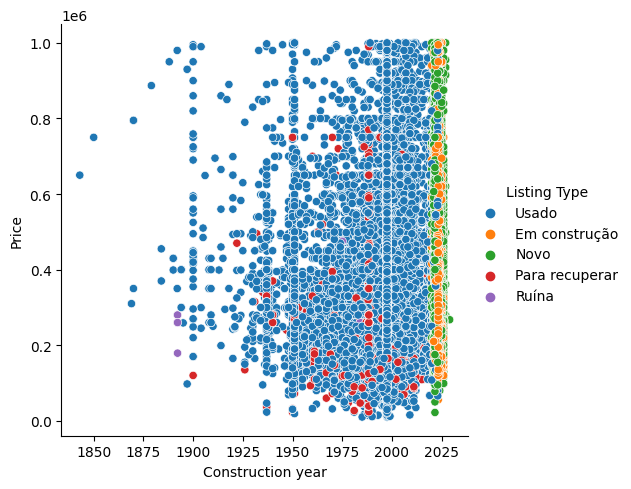

In [66]:
sns.relplot(data=df,x="Construction year", y="Price", hue="Listing Type")

In [67]:
# Fill NaN values with a default value (for example, 'Default Value')
df['Energetic certificate'].fillna('Default Value', inplace=True)

# Map the values to their numeric equivalents
certificate_mapping = {'A+': 7, 'A': 6, 'B+': 5, 'B': 4, 'B-': 3, 'C': 2, 'D': 1, 'E': 0, 'F': -1, 'G': -2, 'Isento / Em Trâmite': -3, 'Default Value': -4}

# Apply the mapping to the DataFrame
df['Energetic certificate'] = df['Energetic certificate'].map(certificate_mapping)

In [68]:
from sklearn.preprocessing import LabelEncoder

# Assuming your DataFrame is named 'df'
# Instantiate the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Listing Type' column to numeric values
df['Listing Type'] = label_encoder.fit_transform(df['Listing Type'])

In [69]:
df.head(5)

,Titles,Price,Location,Rooms,Areas,Bathrooms,Listing Type,Useful area,Gross area,Construction year,Energetic certificate,Enterprise,Neighborhood,City,State
0,Apartamento T2+1 c/ Lugar de Garagem e Arrumo ...,260000.0,"Mafamude e Vilar do Paraíso, Vila Nova de Gaia...",3,106.00,2,4,106.00,121.0,2001.000000,2,0,Mafamude e Vilar do Paraíso,Vila Nova de Gaia,Porto
1,Apartamento T1 para venda na Praia da Rocha,185000.0,"Portimão, Faro",1,58.30,1,4,58.30,68.3,2001.000000,1,0,Portimão,Faro,NaN
2,"Apartamento T4, 2 Suítes, Luxo, Fonte Nova, Av...",950000.0,"Glória e Vera Cruz, Aveiro",4,175.00,4,0,175.00,245.0,2023.000000,7,1,Glória e Vera Cruz,Aveiro,NaN
3,Apartamento T4,780000.0,"Vila do Conde, Porto",4,181.65,0,0,181.65,207.9,2023.274565,4,1,Vila do Conde,Porto,NaN
4,Venda de Apartamento T3 duplex no centro de Vi...,300000.0,"Vila do Conde, Porto",3,183.00,2,4,183.00,183.0,1997.501664,1,0,Vila do Conde,Porto,NaN


**Creating features**

In [70]:
# Create the Square meter per room feature
df['Square Meter per Room'] = ((df['Areas'] / df['Rooms']).replace([np.inf, -np.inf], np.nan)).round(2)

# Create the Square meter per bathroom feature
df['Square Meter per Bathroom'] = ((df['Areas'] / df['Bathrooms']).replace([np.inf, -np.inf], np.nan)).round(2)

# Replace NaN values with 0 in the 'Square_Meter_per_Room' and 'Square_Meter_per_Bathroom' columns
df['Square Meter per Room'].fillna(0, inplace=True)
df['Square Meter per Bathroom'].fillna(0, inplace=True)

# Create the Medium price in the neighborhood feature
df["Medium price neighborhood"] = df.groupby("Neighborhood")["Price"].transform("mean")

# Create the Medium price in the city feature
df["Medium price city"] = df.groupby("City")["Price"].transform("mean")


df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83926 entries, 0 to 89999
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Titles                     83926 non-null  object 
 1   Price                      83926 non-null  float64
 2   Location                   83926 non-null  object 
 3   Rooms                      83926 non-null  int64  
 4   Areas                      83926 non-null  float64
 5   Bathrooms                  83926 non-null  int64  
 6   Listing Type               83926 non-null  int32  
 7   Useful area                83926 non-null  float64
 8   Gross area                 83926 non-null  float64
 9   Construction year          83926 non-null  float64
 10  Energetic certificate      83926 non-null  int64  
 11  Enterprise                 83926 non-null  int64  
 12  Neighborhood               83926 non-null  object 
 13  City                       83529 non-null  object 


In [71]:
city_counts = df['City'].value_counts()

# Display the top cities with their respective sample counts
print(city_counts.head(10))

City
 Lisboa                   9242
 Vila Nova de Gaia        7108
 Porto                    5378
 Matosinhos               3154
 Faro                     3069
 Aveiro                   2823
 São Nicolau e Vitória    2802
 Sintra                   2622
 Seixal                   1755
 Funchal                  1750
Name: count, dtype: int64


**Creating dummies for locations features**

In [72]:
from sklearn.preprocessing import LabelEncoder

# Fill missing Listing Type with 'Usado' (used)
df['Listing Type'].fillna('Usado', inplace=True)

# Perform one-hot encoding using get_dummies
df = pd.get_dummies(df, columns=['Listing Type'])

# Label encoding using LabelEncoder
le = LabelEncoder()
df['Neighborhood_Encoded'] = le.fit_transform(df['Neighborhood'])
df['City_Encoded'] = le.fit_transform(df['City'])
df['State_Encoded'] = le.fit_transform(df['State'])

# Dropping the original categorical columns
df.drop(['Neighborhood', 'City', 'State'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83926 entries, 0 to 89999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Titles                     83926 non-null  object 
 1   Price                      83926 non-null  float64
 2   Location                   83926 non-null  object 
 3   Rooms                      83926 non-null  int64  
 4   Areas                      83926 non-null  float64
 5   Bathrooms                  83926 non-null  int64  
 6   Useful area                83926 non-null  float64
 7   Gross area                 83926 non-null  float64
 8   Construction year          83926 non-null  float64
 9   Energetic certificate      83926 non-null  int64  
 10  Enterprise                 83926 non-null  int64  
 11  Square Meter per Room      83926 non-null  float64
 12  Square Meter per Bathroom  83926 non-null  float64
 13  Medium price neighborhood  83926 non-null  float64


In [73]:
city_counts = df['City_Encoded'].value_counts()

# Display the top cities with their respective sample counts
print(city_counts.head())

City_Encoded
107    9242
241    7108
176    5378
121    3154
79     3069
Name: count, dtype: int64


**Train and test split**

In [74]:
from sklearn.model_selection import train_test_split



selected_cities = [107]

# Filter by City
filtered_df = df[df['City_Encoded'].isin(selected_cities)]

# Defining features and target variable
X = filtered_df.drop(columns=['Price', 'City_Encoded', 'State_Encoded', "Location", "Titles"])  
y = filtered_df['Price']  

# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables: x_ and y_.
X_train, x_, y_train, y_ = train_test_split(X, y, test_size=0.40, random_state=98)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
X_cv, X_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=98)

# Display the shapes of the resulting sets to verify the split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_test shape:", X_cv.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("y_train shape:", y_cv.shape)

X_train shape: (5545, 18)
X_test shape: (1849, 18)
X_test shape: (1848, 18)
y_train shape: (5545,)
y_test shape: (1849,)
y_train shape: (1848,)


**Standarlizing features**

In [75]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale the features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_cv_scaled = scaler.transform(X_cv)

In [76]:
y_train.shape

(5545,)

In [77]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'alpha': [0, 1, 5],
    'lambda': [0, 1, 5]
}

# Initialize XGBoost regressor
xgb_model = XGBRegressor(random_state=98)

# Initialize GridSearchCV
grid_search = GridSearchCV(xgb_model, param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the model with hyperparameter tuning
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Create and train the XGBoost model with the best parameters
best_xgb_model = XGBRegressor(**best_params, verbosity=1, random_state=98)
best_xgb_model.fit(X_train_scaled, y_train, early_stopping_rounds=10, eval_metric="rmse", eval_set=[(X_train_scaled, y_train)])


[0]	validation_0-rmse:205545.72810
[1]	validation_0-rmse:192099.82679
[2]	validation_0-rmse:180293.62186
[3]	validation_0-rmse:169751.77983
[4]	validation_0-rmse:160645.13832
[5]	validation_0-rmse:152534.16385
[6]	validation_0-rmse:145420.37103
[7]	validation_0-rmse:139141.33398
[8]	validation_0-rmse:133348.82920
[9]	validation_0-rmse:128549.58920
[10]	validation_0-rmse:124325.99380
[11]	validation_0-rmse:120512.71741
[12]	validation_0-rmse:117157.93574
[13]	validation_0-rmse:114359.90462
[14]	validation_0-rmse:111714.24501
[15]	validation_0-rmse:109281.55628
[16]	validation_0-rmse:107287.60720
[17]	validation_0-rmse:105393.96648
[18]	validation_0-rmse:103747.88019
[19]	validation_0-rmse:102297.42514
[20]	validation_0-rmse:100971.65383
[21]	validation_0-rmse:99759.27628
[22]	validation_0-rmse:98619.39105
[23]	validation_0-rmse:97597.21816
[24]	validation_0-rmse:96603.56830
[25]	validation_0-rmse:95607.11298
[26]	validation_0-rmse:94688.88464
[27]	validation_0-rmse:93773.77541
[28]	vali

c:\Users\willi\anaconda3\envs\gpu\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\willi\anaconda3\envs\gpu\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[55]	validation_0-rmse:83489.02830
[56]	validation_0-rmse:83278.40535
[57]	validation_0-rmse:83084.95013
[58]	validation_0-rmse:82909.37006
[59]	validation_0-rmse:82722.83061
[60]	validation_0-rmse:82431.17818
[61]	validation_0-rmse:82352.18072
[62]	validation_0-rmse:82051.43470
[63]	validation_0-rmse:81834.92147
[64]	validation_0-rmse:81507.20405
[65]	validation_0-rmse:81185.67231
[66]	validation_0-rmse:81016.97388
[67]	validation_0-rmse:80835.55475
[68]	validation_0-rmse:80699.88248
[69]	validation_0-rmse:80592.51296
[70]	validation_0-rmse:80447.62284
[71]	validation_0-rmse:80225.84173
[72]	validation_0-rmse:79904.54252
[73]	validation_0-rmse:79825.29440
[74]	validation_0-rmse:79701.79695
[75]	validation_0-rmse:79529.12872
[76]	validation_0-rmse:79448.84203
[77]	validation_0-rmse:79353.05070
[78]	validation_0-rmse:79259.34761
[79]	validation_0-rmse:79163.58992
[80]	validation_0-rmse:79127.55375
[81]	validation_0-rmse:78957.95188
[82]	validation_0-rmse:78877.62370
[83]	validation_0-rm

XGBRegressor(alpha=1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=1, learning_rate=0.1,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None, ...)

In [78]:
# Define the XGBRegressor with specified parameters
xgb_model = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.1,
    max_depth=5,
    reg_lambda=45,
    alpha=5,
    verbosity=1,
    random_state=98
)

# Train the XGBoost model
xgb_model.fit(
    X_train_scaled, 
    y_train,
    early_stopping_rounds=10,
    eval_metric="rmse",
    eval_set=[(X_train_scaled, y_train)]
)


[0]	validation_0-rmse:207355.19332
[1]	validation_0-rmse:195147.53848
[2]	validation_0-rmse:184516.02318
[3]	validation_0-rmse:174927.40658
[4]	validation_0-rmse:166436.42158
[5]	validation_0-rmse:158982.46705
[6]	validation_0-rmse:152184.06521
[7]	validation_0-rmse:146130.51852
[8]	validation_0-rmse:140758.50431
[9]	validation_0-rmse:135982.89432


[10]	validation_0-rmse:131702.54048
[11]	validation_0-rmse:127845.98107
[12]	validation_0-rmse:124429.90081
[13]	validation_0-rmse:121516.70691
[14]	validation_0-rmse:118790.98081
[15]	validation_0-rmse:116198.26603
[16]	validation_0-rmse:114111.71493
[17]	validation_0-rmse:112203.34346
[18]	validation_0-rmse:110252.88775
[19]	validation_0-rmse:108759.44943
[20]	validation_0-rmse:107302.09446
[21]	validation_0-rmse:105967.88930
[22]	validation_0-rmse:104593.41814
[23]	validation_0-rmse:103475.01753
[24]	validation_0-rmse:102485.20594
[25]	validation_0-rmse:101493.13664
[26]	validation_0-rmse:100683.63641
[27]	validation_0-rmse:99909.47056
[28]	validation_0-rmse:99055.19835
[29]	validation_0-rmse:98349.81643
[30]	validation_0-rmse:97577.79695
[31]	validation_0-rmse:96986.57798
[32]	validation_0-rmse:96403.50657
[33]	validation_0-rmse:95712.86995
[34]	validation_0-rmse:95196.90879
[35]	validation_0-rmse:94784.93450
[36]	validation_0-rmse:94408.08571
[37]	validation_0-rmse:93966.67148
[38

XGBRegressor(alpha=5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, ...)

In [79]:
predictions_train = best_xgb_model.predict(X_train_scaled)
predictions_cv = best_xgb_model.predict(X_cv_scaled)
predictions_test = best_xgb_model.predict(X_test_scaled)

In [80]:
# Analyse Train predictions
analysis.evaluate_model_performance(y_cv, predictions_cv)

{'MAE': 62594.290795792745,
 'MSE': 7954115163.418456,
 'RMSE': 89185.84620565338,
 'R2': 0.8374945609768921}

In [81]:
# Analyse CV predictions
analysis.evaluate_model_performance(y_test, predictions_test)

{'MAE': 62176.96143079874,
 'MSE': 7776401929.096705,
 'RMSE': 88183.90969500448,
 'R2': 0.8429828923607505}

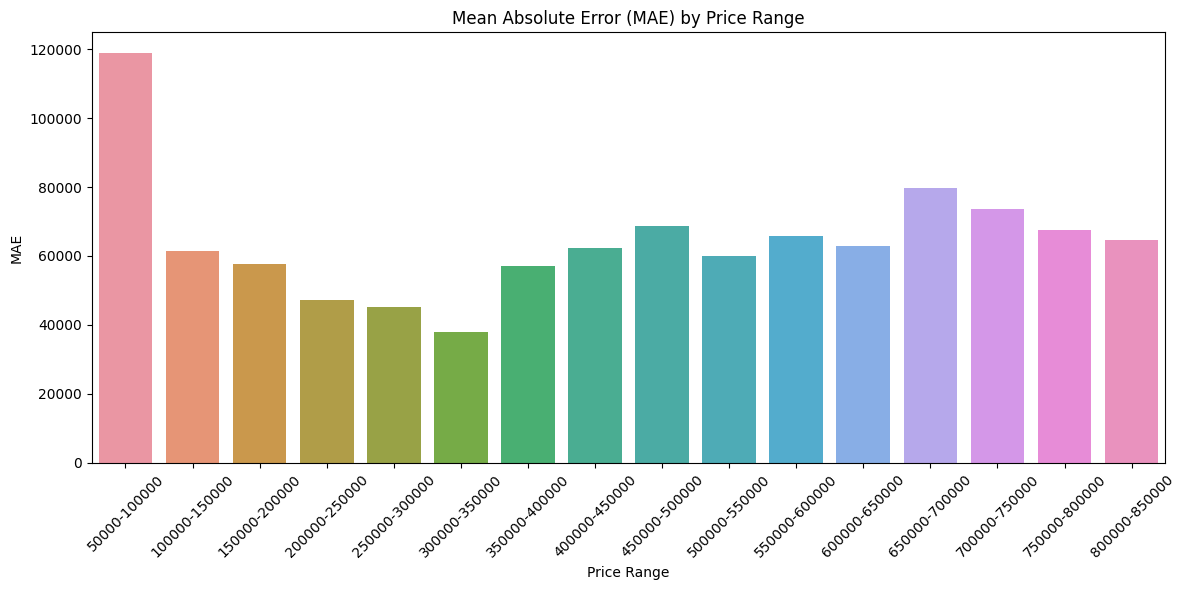

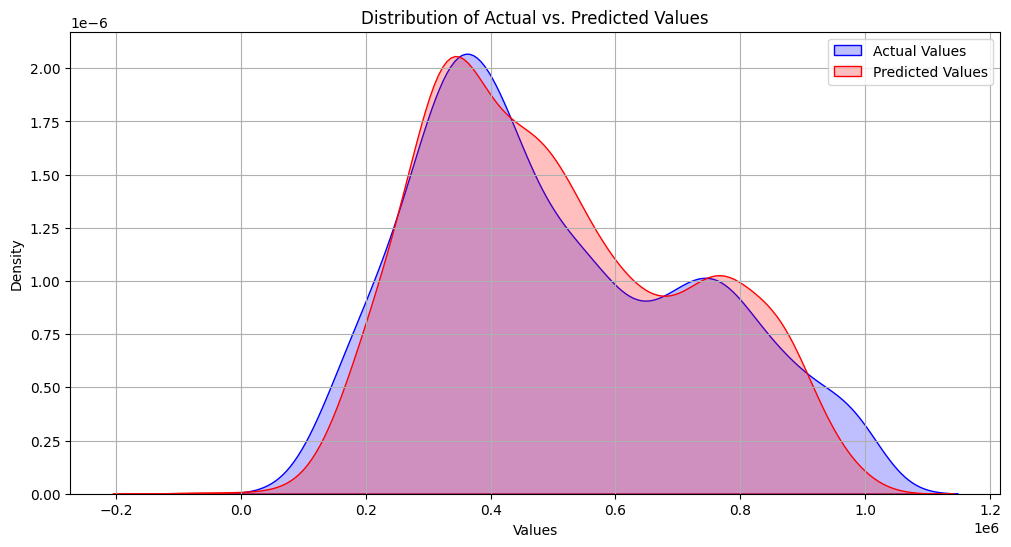

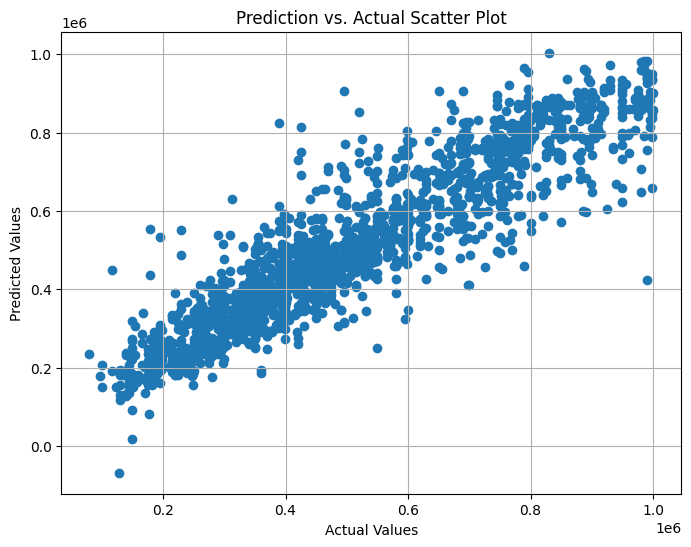

In [82]:
# Call the modified analyze_precision function
analysis.analyze_precision(X_test, y_test, predictions_test)